In [1]:
import numpy as np
from scipy import signal as sgl
from matplotlib import pyplot as plt
import numba
import matplotlib as mpl
from lib.parameters_info import sample_uniform_within_range
mpl.rcParams['font.size'] = 20

In [2]:
@numba.njit
def simulate_connected_heun_noise(
            parameters,
            connectivity,
            coupling = 0.1,
            conduction_speed = 10.0,
            length: int = 302,
            dt: int = 1,
            initial_conditions = np.array([0.25,0.25]),
            noise_seed: int = 42,
            input_connections = np.array(([1.0, 0.0])),
            store_I: bool = True
    ):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Set seet
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-1]* dt), np.sqrt(2*params[-2]* dt)
    num_nodes = connectivity.shape[1] 
    remove_diagonal = np.ones_like(connectivity[0]) - np.eye(num_nodes)
    connectivity[0] *= remove_diagonal
    connectivity[1] *= remove_diagonal
    delay = (1/dt*connectivity[1]/conduction_speed).astype("int32") # nxn where delay[i] = [index of delay with self, index of delay with node 1, index of delay with node 2, ...]
    # Equivalent to allocating memory

    sim_length = int(1000/dt*length)
    time_series_E = np.zeros((sim_length+1, int(num_nodes)))
    time_series_I = np.zeros((3,int(num_nodes)))
    if store_I:
        time_series_I = np.empty((sim_length+1,int(num_nodes)))
    time_series_E_input = np.zeros((2,int(num_nodes)))
    time_series_E_temp = np.empty((1,int(num_nodes)))
    time_series_I_temp = np.empty((1,int(num_nodes)))
    time_series_E_corr = np.empty((1,int(num_nodes)))
    time_series_I_corr = np.empty((1,int(num_nodes)))
    time_series_E_noise = np.empty((1,int(num_nodes)))
    time_series_I_noise = np.empty((1,int(num_nodes)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    input_delayed = np.zeros((int(num_nodes)))
    input_delayed_heun = np.zeros((int(num_nodes)))
    # Heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(int(1000/dt*length)-1):
        # Forward Euler
        j_0 = i
        j_1 = (i+1)
        if not store_I:
            j_0 = i%2
            j_1 = (i+1)%2
        # Calculating input from other nodes
        if i > np.max(delay):
            for j in range(num_nodes):
                input_delayed *= 0
                input_delayed_heun *= 0
                temp_delay = np.where(i < delay[j], -1, delay[j])
                input_delayed += np.diag(time_series_E[i-temp_delay])
                time_series_E_input[0][j] = np.dot(input_delayed, connectivity[0][j])
                #temp_delay_heun = temp_delay-1
                temp_delay = np.where(i < delay[j]-1, -1, delay[j]-1)
                input_delayed_heun  += np.diag(time_series_E[i-temp_delay])
                time_series_E_input[1][j] = np.dot(input_delayed_heun, connectivity[0][j])
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[j_0] + params[18] - params[9]
        time_series_I[j_1] = params[1] * time_series_E[i] - params[3] * time_series_I[j_0] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7] + input_connections[0] * coupling * dt * time_series_E_input[0])))
        time_series_I[j_1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[j_1] - params[11] + input_connections[1] * coupling * dt * time_series_E_input[0])))
        time_series_E[i+1] = dt*(((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[j_1] = dt*(((params[17] - params[15] * time_series_I[j_0]) * time_series_I[j_1]) - time_series_I[j_0]) / params[5] 
        time_series_E_noise = np.random.normal(0,1,size=num_nodes) *  DE 
        time_series_I_noise = np.random.normal(0,1,size=num_nodes) *  DI 
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] + time_series_E_noise
        time_series_I_temp = time_series_I[j_0] + time_series_I[j_1] + time_series_I_noise
        # Corrector point
        time_series_E_corr = params[0] * time_series_E_temp - params[2] * time_series_I_temp + params[18] - params[9]
        time_series_I_corr = params[1] * time_series_E_temp - params[3] * time_series_I_temp + params[19] - params[13]
        time_series_E_corr = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E_corr - params[7] + input_connections[0] * coupling * dt * time_series_E_input[1])))
        time_series_I_corr = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I_corr - params[11] + input_connections[1] * coupling * dt * time_series_E_input[1])))
        time_series_E_corr = dt*(((params[16] - params[14] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        time_series_I_corr = dt*(((params[17] - params[15] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 + time_series_E_noise
        time_series_I[j_1] = time_series_I[j_0] + (time_series_I[j_1]+time_series_I_corr)/2 + time_series_I_noise
        # Correcting for ceiling and floor of activity
        time_series_E[i+1] = np.where(time_series_E[i+1] > 1.0, 1.0, time_series_E[i+1])
        time_series_I[j_1] = np.where(time_series_I[j_1] > 1.0, 1.0, time_series_I[j_1])
        time_series_E[i+1] = np.where(time_series_E[i+1] < 0.0, 0, time_series_E[i+1])
        time_series_I[j_1] = np.where(time_series_I[j_1] < 0.0, 0, time_series_I[j_1])
        
    return time_series_E[:-2], time_series_I[:-2]

@numba.njit
def simulate_connected_heun_noise_faster(
            parameters,
            connectivity,
            coupling = 0.1,
            conduction_speed = 10.0,
            length: int = 302,
            dt: int = 1,
            initial_conditions = np.array([0.25,0.25]),
            noise_seed: int = 42,
            input_connections = np.array(([1.0, 0.0])),
            store_I: bool = True
    ):
    # Input parameters are of shape (num_nodes, num_parameters) to match parameter estimation output, but we need (num_parameters,num_nodes) to simulate
    params = parameters.T 
    # Set seet
    np.random.seed(noise_seed)
    # White noise
    DE, DI = np.sqrt(2*params[-1]* dt), np.sqrt(2*params[-2]* dt)
    num_nodes = connectivity.shape[1] 
    remove_diagonal = np.ones_like(connectivity[0]) - np.eye(num_nodes)
    connectivity[0] *= remove_diagonal
    connectivity[1] *= remove_diagonal
    
    # Kernel for delay to allow vectorized calculation of inputs (improves speed for large num_nodes)
    
    delay = (1/dt*connectivity[1]/conduction_speed).astype("int64")
    
    max_delay = np.max(delay)
    if max_delay == 0:
        max_delay = 1
    kernel = np.zeros((num_nodes, max_delay, num_nodes))
    #print(kernel.shape)
    for i in range(num_nodes):
        for j in range(num_nodes):
            kernel[i][-delay[i][j]][j] = connectivity[0][i][j]
    # Equivalent to allocating memory
    sim_length = int(1000/dt*length)
    time_series_E = np.zeros((sim_length+1, int(num_nodes)))
    time_series_I = np.zeros((3,int(num_nodes)))
    if store_I:
        time_series_I = np.empty((sim_length+1,int(num_nodes)))
    time_series_E_input = np.zeros((2,int(num_nodes)))
    time_series_E_temp = np.empty((1,int(num_nodes)))
    time_series_I_temp = np.empty((1,int(num_nodes)))
    time_series_E_corr = np.empty((1,int(num_nodes)))
    time_series_I_corr = np.empty((1,int(num_nodes)))
    time_series_E_noise = np.empty((1,int(num_nodes)))
    time_series_I_noise = np.empty((1,int(num_nodes)))
    # Set initial conditions
    time_series_E[0] = initial_conditions[0]
    time_series_I[0] = initial_conditions[1]
    # Heun performed in-place within the time_series_X arrays to maximize speed
    for i in range(sim_length-1):
        
        # Forward Euler
        j_0 = i
        j_1 = (i+1)
        if not store_I:
            j_0 = i%2
            j_1 = (i+1)%2
        # Calculating input from other nodes (vectorized)
        if i > max_delay and i+1 < sim_length-max_delay:
            time_series_E_input[0] = np.sum((time_series_E[i-max_delay:i,:] * kernel).reshape((num_nodes, -1)), 1)
        time_series_E[i+1] = params[0] * time_series_E[i] - params[2] * time_series_I[j_0] + params[18] - params[9]
        time_series_I[j_1] = params[1] * time_series_E[i] - params[3] * time_series_I[j_0] + params[19] - params[13]
        time_series_E[i+1] = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E[i+1] - params[7] + input_connections[0] * coupling * dt * time_series_E_input[0])))
        time_series_I[j_1] = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I[j_1] - params[11] + input_connections[1] * coupling * dt * time_series_E_input[0])))
        time_series_E[i+1] = dt*(((params[16] - params[14] * time_series_E[i]) * time_series_E[i+1]) - time_series_E[i]) / params[4] 
        time_series_I[j_1] = dt*(((params[17] - params[15] * time_series_I[j_0]) * time_series_I[j_1]) - time_series_I[j_0]) / params[5] 
        time_series_E_noise = np.random.normal(0,1,size=num_nodes) *  DE 
        time_series_I_noise = np.random.normal(0,1,size=num_nodes) *  DI 
        time_series_E_temp = time_series_E[i] + time_series_E[i+1] + time_series_E_noise
        time_series_I_temp = time_series_I[j_0] + time_series_I[j_1] + time_series_I_noise
        # Corrector point
        # Calculating input from other nodes (vectorized)
        if i > max_delay and i+1 < sim_length-max_delay:
            time_series_E_input[0] = np.sum((time_series_E[i+1-max_delay:i+1,:] * kernel).reshape((num_nodes, -1)), 1)
        time_series_E_corr = params[0] * time_series_E_temp - params[2] * time_series_I_temp + params[18] - params[9]
        time_series_I_corr = params[1] * time_series_E_temp - params[3] * time_series_I_temp + params[19] - params[13]
        time_series_E_corr = params[8] / (1 + np.exp(-params[6]* (params[20] * time_series_E_corr - params[7] + input_connections[0] * coupling * dt * time_series_E_input[1])))
        time_series_I_corr = params[12] / (1 + np.exp(-params[10]* (params[21] * time_series_I_corr - params[11] + input_connections[1] * coupling * dt * time_series_E_input[1])))
        time_series_E_corr = dt*(((params[16] - params[14] * time_series_E_temp) * time_series_E_corr) - time_series_E_temp) / params[4] 
        time_series_I_corr = dt*(((params[17] - params[15] * time_series_I_temp) * time_series_I_corr) - time_series_I_temp) / params[5]
        # Heun point
        time_series_E[i+1] = time_series_E[i] + (time_series_E[i+1]+time_series_E_corr)/2 + time_series_E_noise
        time_series_I[j_1] = time_series_I[j_0] + (time_series_I[j_1]+time_series_I_corr)/2 + time_series_I_noise
        # Correcting for ceiling and floor of activity
        time_series_E[i+1] = np.where(time_series_E[i+1] > 1.0, 1.0, time_series_E[i+1])
        time_series_I[j_1] = np.where(time_series_I[j_1] > 1.0, 1.0, time_series_I[j_1])
        time_series_E[i+1] = np.where(time_series_E[i+1] < 0.0, 0, time_series_E[i+1])
        time_series_I[j_1] = np.where(time_series_I[j_1] < 0.0, 0, time_series_I[j_1])
        
    return time_series_E[:-2], time_series_I[:-2]



In [17]:
num_nodes = 68
parameters = np.array([[
        1.6000e+01, 1.2000e+01, 1.5000e+01, 3.0000e+00,
        8.0000e+00, 8.0000e+00,
        1.3000e+00, 4.0000e+00, 1.0000e+00, 0.0000e+00,
        2.0000e+00, 3.7000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.5000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00,
        0.0000e-06, 0.0000e-06
] for i in range(num_nodes)
])

#print(parameters.shape)
connectivity = np.array([
        [
                [0.00, 0.75, 0.50],
                [0.75, 0.00, 0.25],
                [0.50, 0.25, 0.00],
        ],
        [
                [0.00, 25.0, 50.0],
                [25.0, 0.00, 75.0],
                [50.0, 75.0, 0.00],
        ]
])
connectivity = np.random.rand(2,num_nodes,num_nodes)
connectivity[1] *= 20
input_connections = np.array([1.0, 1.0])
coupling = 0.1
conduction_speed = 15.0
length = 10.0 
dt = 0.25
initial_conditions = np.array([0.25,0.25])
noise_seed = 42
store_I = True
time_series_E, time_series_I = simulate_connected_heun_noise(
                                                                parameters,
                                                                connectivity,
                                                                coupling = coupling,
                                                                conduction_speed=conduction_speed,
                                                                length=length,
                                                                dt = dt,
                                                                initial_conditions=initial_conditions,
                                                                store_I = store_I,
                                                                input_connections=input_connections
                                                        )
input_connections = np.array([0.0, 0.0])
time_series_E, time_series_I = simulate_connected_heun_noise_faster(
                                                                parameters,
                                                                connectivity,
                                                                coupling = coupling,
                                                                conduction_speed=conduction_speed,
                                                                length=length,
                                                                dt = dt,
                                                                initial_conditions=initial_conditions,
                                                                store_I = store_I,
                                                                input_connections=input_connections
                                                        )

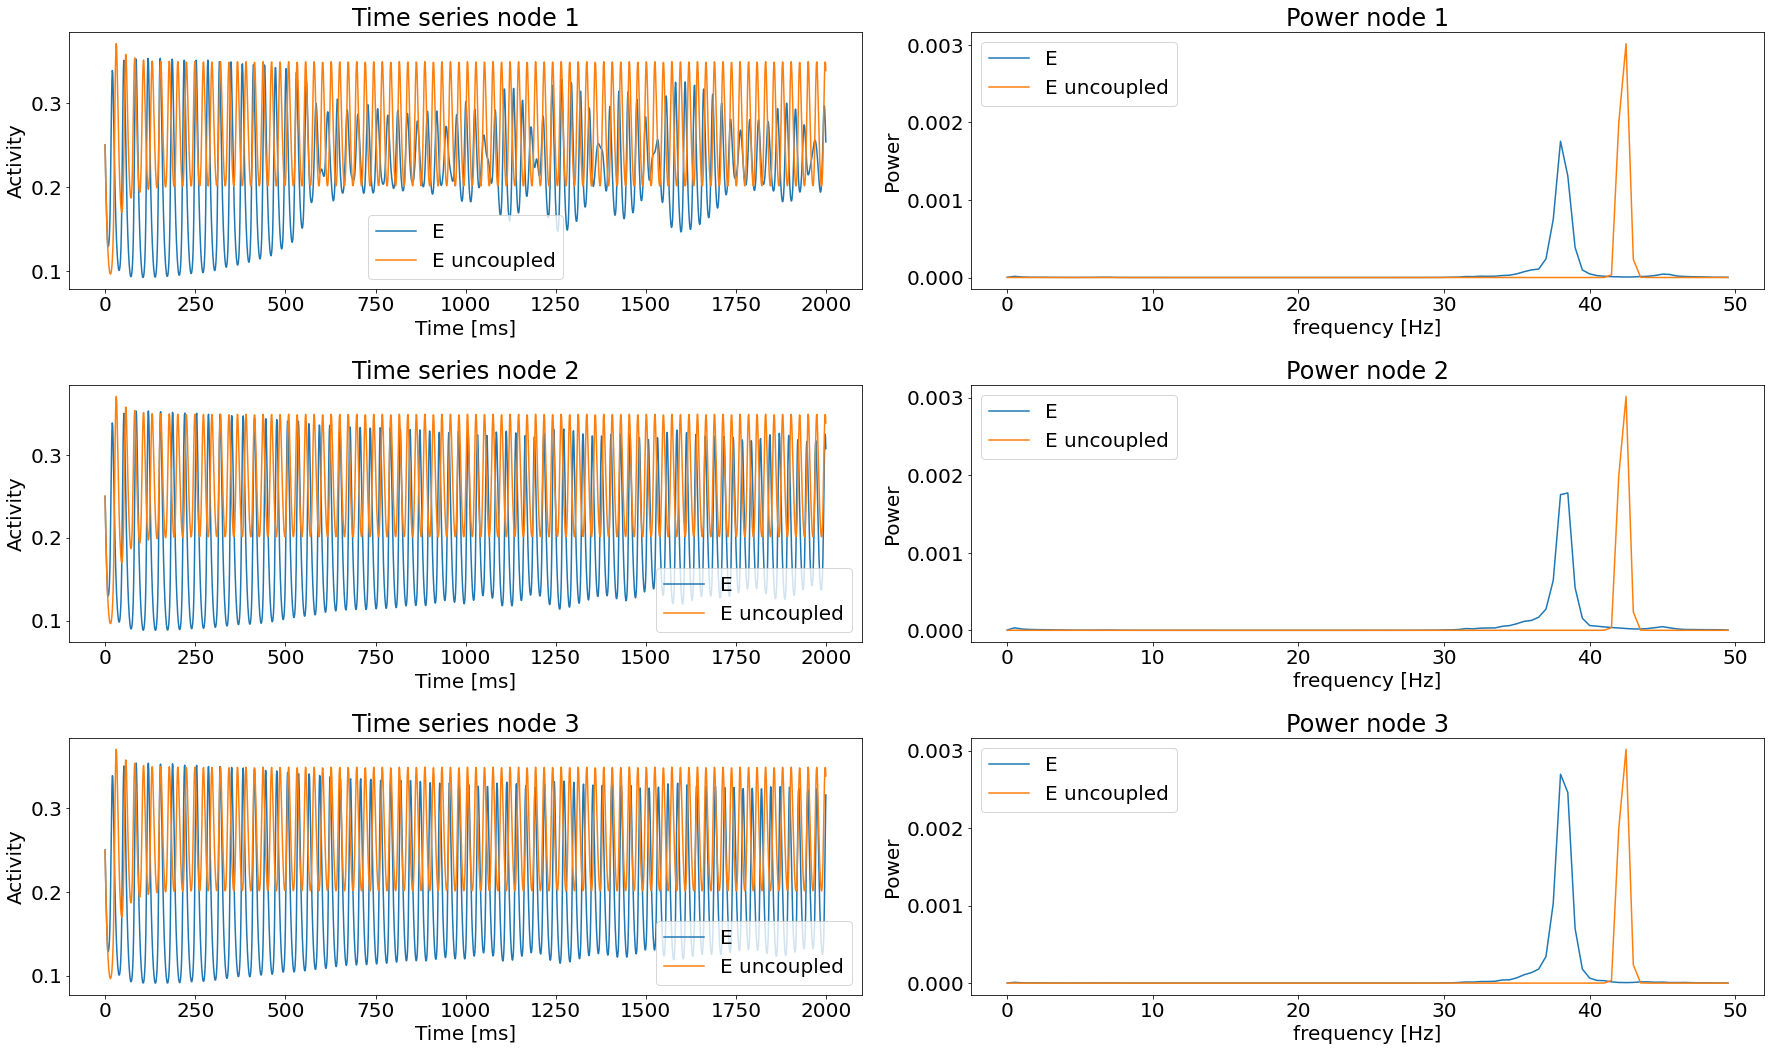

In [48]:
# Plot
tstart = 0
tend = 2
t = np.arange(int((tend-tstart) * 1000/dt))*dt

f = plt.figure(figsize=(25,15))
# Timeseries
ax = plt.subplot(3,2,1)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 1')
plt.legend()
# PSD
ax = plt.subplot(3,2,2)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 1')
plt.legend()

# Timeseries
ax = plt.subplot(3,2,3)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 2')
plt.legend()
# PSD
ax = plt.subplot(3,2,4)
f , psd = sgl.welch(time_series_E[:,1],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,1],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,1],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 2')
plt.legend()

# Timeseries
ax = plt.subplot(3,2,5)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 3')
plt.legend()
# PSD
ax = plt.subplot(3,2,6)
f , psd = sgl.welch(time_series_E[:,2],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,2],fs=(1000/dt), nperseg=2000/dt)
plt.plot(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,2],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 3')
plt.legend()
plt.tight_layout()
plt.show()

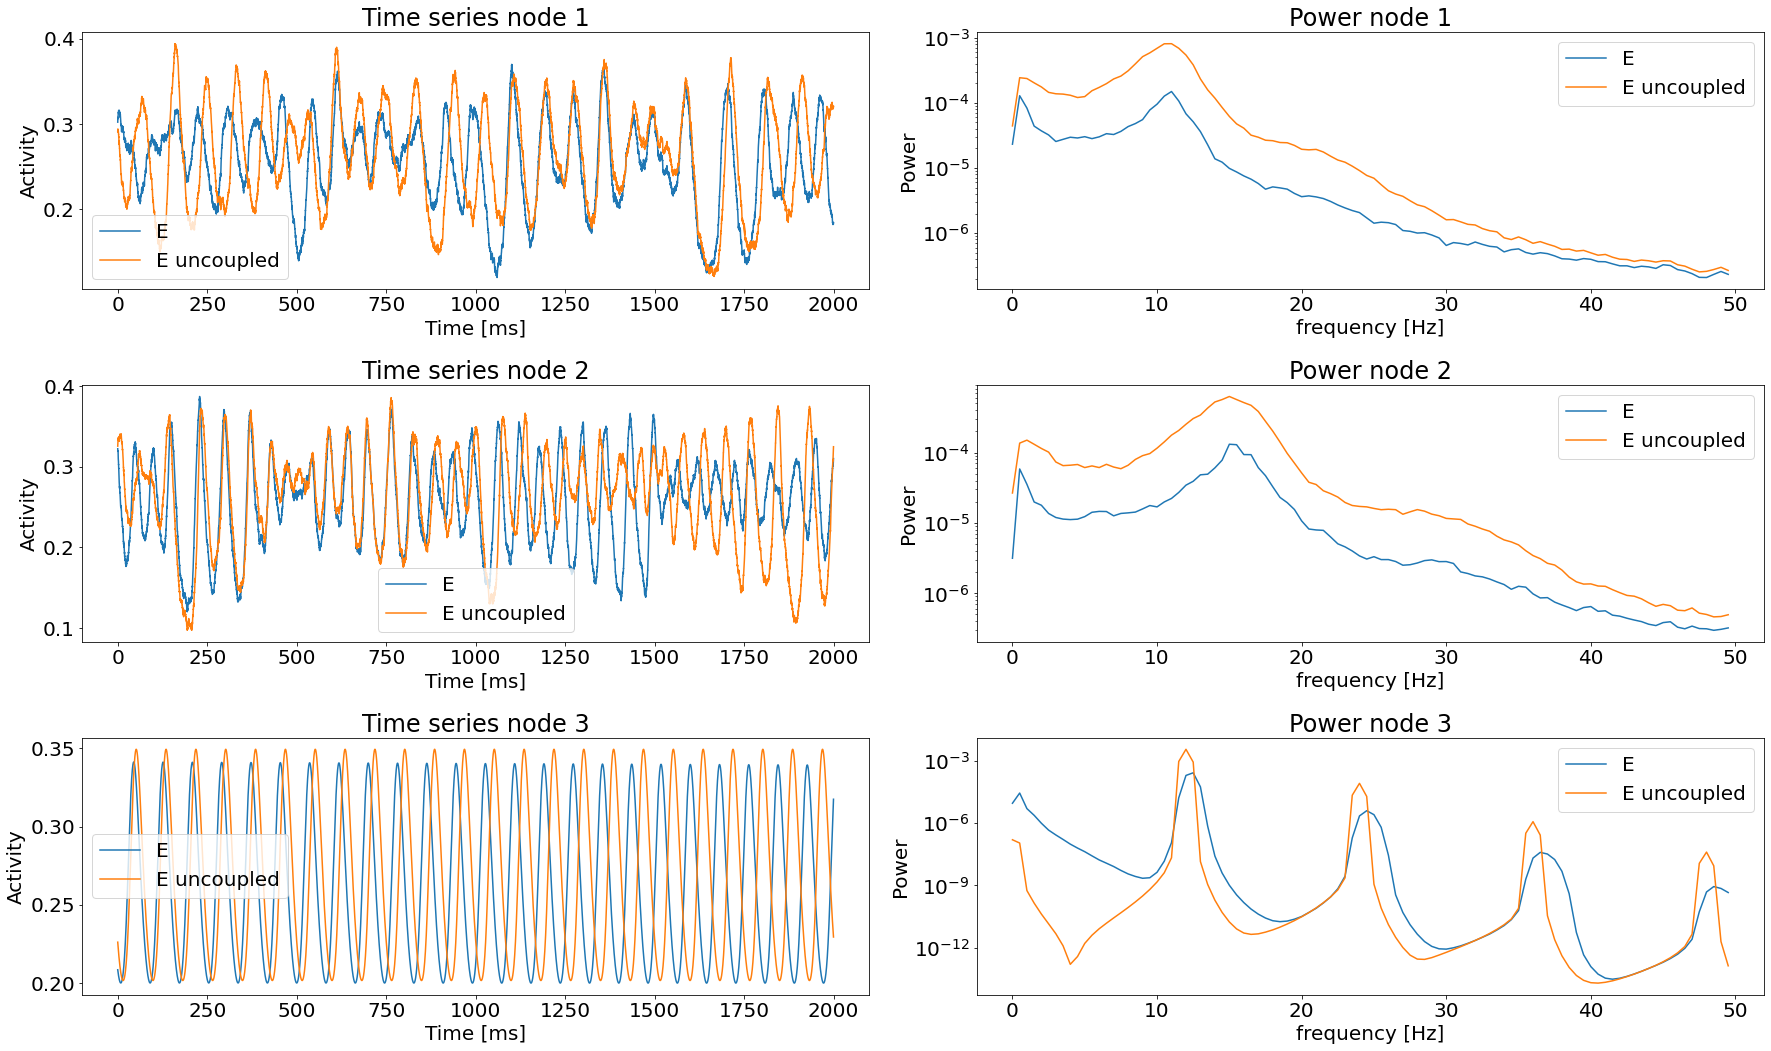

In [68]:
# Plot
tstart = 10
tend = 12
t = np.arange(int((tend-tstart) * 1000/dt))*dt

f = plt.figure(figsize=(25,15))
# Timeseries
ax = plt.subplot(3,2,1)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),0], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 1')
plt.legend()
# PSD
ax = plt.subplot(3,2,2)
f , psd = sgl.welch(time_series_E[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,0],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,0],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 1')
plt.legend()

# Timeseries
ax = plt.subplot(3,2,3)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),1], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 2')
plt.legend()
# PSD
ax = plt.subplot(3,2,4)
f , psd = sgl.welch(time_series_E[:,1],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,1],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,1],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 2')
plt.legend()

# Timeseries
ax = plt.subplot(3,2,5)
ax.plot(t,time_series_E[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "E")
ax.plot(t,time_series_E_uncoupled[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "E uncoupled")
#ax.plot(t,time_series_I[int(tstart * 1000/dt):int(tend * 1000/dt),2], label = "I")
plt.xlabel('Time [ms]')
plt.ylabel('Activity')
plt.title('Time series node 3')
plt.legend()
# PSD
ax = plt.subplot(3,2,6)
f , psd = sgl.welch(time_series_E[:,2],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E")
f , psd = sgl.welch(time_series_E_uncoupled[:,2],fs=(1000/dt), nperseg=2000/dt)
plt.semilogy(f[:100],psd[:100], label = "E uncoupled")
#f , psd = sgl.welch(time_series_I[:,2],fs=(1000/dt), nperseg=2000/dt)
#plt.plot(f[:100],psd[:100], label = "I")
plt.xlabel('frequency [Hz]')
plt.ylabel('Power')
plt.title('Power node 3')
plt.legend()
plt.tight_layout()
plt.show()